In [1]:
import numpy as np
import pandas as pd
import bloscpack as bp

import imgaug as ia
import imgaug.augmenters as iaa

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.model_selection import StratifiedKFold

from torch.utils.data.dataloader import DataLoader

import fastai
from fastai.vision import *

from optim import Over9000
from data import Bengaliai_DS, Balanced_Sampler
from model import *
from model_utils import *
from MG_models import LocNCls_Single

---

In [2]:
SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

---
### data

In [3]:
augs = iaa.SomeOf(
    (0, 2),
    [
        iaa.SomeOf(
            (1, 2),
            [
                iaa.OneOf(
                    [
                        iaa.Affine(scale={"x": (0.8, 1.), "y": (0.8, 1.)}, rotate=(-15, 15), shear=(-15, 15)),
                        iaa.PerspectiveTransform(scale=.08, keep_size=True),
                    ]
                ),
                iaa.PiecewiseAffine(scale=(0.02, 0.03)),
            ],
            random_order=True
        ),
        iaa.DirectedEdgeDetect(alpha=(.6, .8), direction=(0.0, 1.0)),
    ],
    random_order=True
)

In [4]:
pdf = pd.read_csv('../input/train.csv')

unique_grapheme = pdf['grapheme'].unique()
grapheme_code = dict([(g, c) for g, c in zip(unique_grapheme, np.arange(unique_grapheme.shape[0]))])
pdf['grapheme_code'] = [grapheme_code[g] for g in pdf['grapheme']]

skf = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)
for trn_ndx, vld_ndx in skf.split(pdf['grapheme_code'], pdf['grapheme_code']):
    break
    
trn_pdf = pdf.iloc[trn_ndx, :]
trn_pdf.reset_index(inplace=True, drop=True)
imgs = bp.unpack_ndarray_from_file('../features/train_images_size128_pad0.bloscpack')
lbls = pd.read_csv('../input/train.csv').iloc[:, 1:4].values

trn_imgs = imgs[trn_ndx]
trn_lbls = lbls[trn_ndx, 0:1]
vld_imgs = imgs[vld_ndx]
vld_lbls = lbls[vld_ndx, 0:1]

In [5]:
# sampler = Balanced_Sampler(trn_pdf, count_column='image_id', primary_group='grapheme_root', secondary_group=['vowel_diacritic', 'consonant_diacritic'], size=trn_imgs.shape[0])

training_set = Bengaliai_DS(trn_imgs, trn_lbls, transform=augs)
validation_set = Bengaliai_DS(vld_imgs, vld_lbls)

training_loader = DataLoader(training_set, batch_size=168, num_workers=6, shuffle=True) # , sampler=sampler , shuffle=True
validation_loader = DataLoader(validation_set, batch_size=168, num_workers=6, shuffle=False)

data_bunch = DataBunch(train_dl=training_loader, valid_dl=validation_loader)

In [10]:
for a, b in validation_loader:
    break

In [12]:
c = classifier.stn(a.cuda())

In [13]:
c.shape

torch.Size([168, 1, 128, 128])

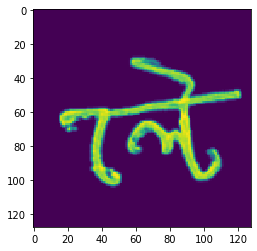

In [22]:
anp = a.data.cpu().numpy()
anp = anp * 0.2051 + 0.0692
plt.imshow(anp[4, 0])

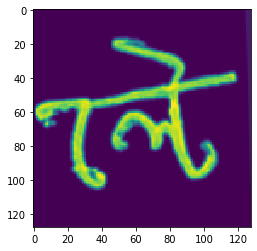

In [23]:
cnp = c.data.cpu().numpy()
cnp = cnp * 0.2051 + 0.0692
plt.imshow(cnp[4, 0])

---
### model

In [6]:
device = 'cuda:0'
n_grapheme = 168
n_vowel = 11
n_consonant = 7
n_total = n_grapheme + n_vowel + n_consonant

In [7]:
classifier = LocNCls_Single(n_grapheme)

In [8]:
learn = Learner(
    data_bunch,
    classifier,
    loss_func=Loss_single(),
    opt_func=Over9000,
    metrics=[Metric_grapheme()]
)

logger = CSVLogger(learn, 'seresnext50_stn_singleclass_1of7')

# learn.clip_grad = 1.0
# learn.split([classifier.predictor.lin_layers])
# learn.split([classifier.head1])
learn.unfreeze()

In [9]:
learn.fit_one_cycle(
    96,
    #max_lr=slice(0.2e-2, 1e-2),
    max_lr=1e-2,
    wd=0.,
    pct_start=0.0,
    div_factor=100,
    callbacks=[logger, SaveModelCallback(learn, monitor='metric_idx', mode='max', name='seresnext50_stn_singleclass_1of7'), MixUpCallback_Single(learn)] # 
)

epoch,train_loss,valid_loss,metric_idx,time
0,1.653641,0.859407,0.730456,06:55
1,1.515096,0.422436,0.862381,06:50
2,1.354090,0.316377,0.905598,06:51
3,1.271218,0.233097,0.929286,06:50
4,1.186834,0.212105,0.927480,06:51
5,1.119828,0.196118,0.938130,06:51
6,1.072501,0.208189,0.939828,06:50
7,1.015595,0.205707,0.930887,06:50
8,0.996370,0.183645,0.940437,06:50
9,0.929132,0.170933,0.946324,06:51


/home/yuan/miniconda3/envs/ML/lib/python3.7/site-packages/torch/nn/functional.py:2764: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/home/yuan/miniconda3/envs/ML/lib/python3.7/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/yuan/miniconda3/envs/ML/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/yuan/miniconda3/envs/ML/lib

KeyboardInterrupt: 